In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde

from sklearn.decomposition import PCA

from snmcseq_utils import plot_tsne_values
from snmcseq_utils import plot_tsne_labels
from snmcseq_utils import tsne_and_boxplot

In [2]:
mc_c_file = './data/gene_level/genebody_mCH_human_combined_summary.tsv'
df = pd.read_table(mc_c_file, index_col='id')
print(df.shape)

(57240, 12870)


In [3]:
meta_file = './data/metadata/metadata_human_combined_updated.tsv' 
cluster_file = './data/cluster/cluster_MB_v1_MB_EA_MB_EB/clusters_binc_mCHmCG_human_combined_100000_summary_normalized.tsv'
tsne_file = './data/tsne/old/tsne_perp50_binc_mCHmCG_human_combined_100000_summary_normalized.tsv'
gene_id_name_file = './data/references/gene_id_to_names.tsv'
annotation_file = './data/cluster/cluster_MB_v1_MB_EA_MB_EB/cluster_MB_v1_MB_EA_MB_EB_annotation.tsv'

df_meta = pd.read_table(meta_file, index_col='Sample')
df_cluster = pd.read_table(cluster_file, index_col='sample')
df_tsne = pd.read_table(tsne_file, index_col='sample')
df_gene = pd.read_table(gene_id_name_file, index_col='geneID')
df_annot = pd.read_table(annotation_file, index_col='cluster_ID')

df_cluster = pd.merge(df_cluster, df_annot, left_on='cluster_ID', right_index=True)

print(df_meta.shape)
print(df_tsne.shape)
print(df_cluster.shape)
print(df_gene.shape)

df_info = pd.merge(df_meta, df_cluster, left_index=True, right_index=True)
df_info = pd.merge(df_info, df_tsne, left_index=True, right_index=True)
print(df_info.shape)

(6435, 16)
(6435, 3)
(6435, 2)
(57820, 5)
(6435, 21)


In [4]:
df_mc = df.filter(regex='_mc')
df_c = df.filter(regex='_c')

df_mc.columns = [col[:-len('_mc')] for col in df_mc.columns]
df_c.columns = [col[:-len('_c')] for col in df_c.columns]

print(df_mc.shape)
print(df_c.shape)


# cells = df_info[df_info.cluster_ID=='cluster_52'].index.values
# cells_1 = df_info[(df_info.cluster_ID=='cluster_52') & (df_info.Biosample=='MB_v1')].index.values
# cells_2 = df_info[(df_info.cluster_ID=='cluster_52') & (df_info.Biosample=='MB_EA')].index.values
# cells_3 = df_info[(df_info.cluster_ID=='cluster_52') & (df_info.Biosample=='MB_EB')].index.values
# print(cells.shape)
# print(cells_1.shape)
# print(cells_2.shape)
# print(cells_3.shape)

(57240, 6435)
(57240, 6435)


In [5]:
# filter out genes with low coverage
# doing imputation
# get gene*cell matrix

# cutoff = 100
# cov = (df_c >= cutoff)*1
# gene_cov = cov.apply(np.all, axis=1)
# df_mccf = df_mcc.loc[gene_cov, :]
# print(df_mccf.shape)
# sns.heatmap(cov)
# plt.show()# low coverage


# remove low coverage gene

base_call_cutoff = 100 
sufficient_coverage_fraction = 0.98 
condition = (df_c > base_call_cutoff).sum(axis=1) >= sufficient_coverage_fraction*(df.shape[1])/2.0 


print("Matrix size before pruning... "+ str(df.shape))
df_f = df.loc[condition]
print("Matrix size after pruning... "+ str(df_f.shape))

# get mcc matrix with kept bins and nan values for low coverage sites
df_c_nan = df_c.copy()
df_c_nan[df_c < base_call_cutoff] = np.nan
df_mcc = df_mc.loc[condition]/df_c_nan.loc[condition]
print(df_mcc.shape)

# imputation (missing value -> mean value of all cells)
print('Imputing data...')
means = df_mcc.mean(axis=1)
fill_value = pd.DataFrame({col: means for col in df_mcc.columns})
df_mcc.fillna(fill_value, inplace=True)

# add "_mcc" suffix
df_mcc.columns = df_mcc.columns.values + '_mcc'


Matrix size before pruning... (57240, 12870)
Matrix size after pruning... (10142, 12870)
(10142, 6435)
Imputing data...


2784
2347
1304


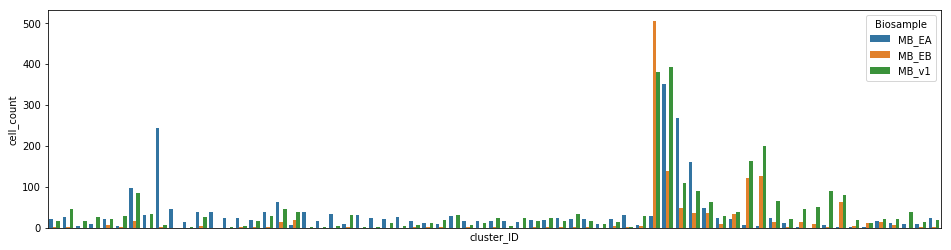

In [6]:
"""
For every cluster, plot biosample related quantities
"""
cell_count1 = df_info[df_info.Biosample=='MB_v1'].shape[0]
cell_count2 = df_info[df_info.Biosample=='MB_EA'].shape[0]
cell_count3 = df_info[df_info.Biosample=='MB_EB'].shape[0]
print(cell_count1)
print(cell_count2)
print(cell_count3)

df_counts = df_info.groupby(['cluster_ID', 'Biosample']).count()['mCH/CH'].to_frame()
df_counts.reset_index(level=['cluster_ID', 'Biosample'], inplace=True)
df_counts.columns = ['cluster_ID', 'Biosample', 'cell_count']

fig, ax = plt.subplots(figsize=(16, 4))
ax = sns.barplot(x="cluster_ID", y="cell_count", hue="Biosample", data=df_counts)
ax.set_xticks([])
plt.show()

In [15]:
df_sample_counts = df_info.groupby('Biosample').count()['mCH/CH'].to_frame()
df_sample_counts.columns = ['tc_biosample']
df_counts_new = pd.merge(df_counts, df_sample_counts, left_on='Biosample', right_index=True)
df_counts_new['cell_ratio'] = df_counts_new.cell_count/df_counts_new.tc_biosample


df_cluster_counts = df_info.groupby('cluster_ID').count()['mCH/CH'].to_frame()
df_cluster_counts.columns = ['tc_cluster']
df_counts_new = pd.merge(df_counts_new, df_cluster_counts, left_on='cluster_ID', right_index=True)
df_counts_new['cell_ratio_cluster'] = df_counts_new.cell_count/df_counts_new.tc_cluster

df_counts_new.head()

,cluster_ID,Biosample,cell_count,tc_biosample,cell_ratio,tc_cluster,cell_ratio_cluster
0,cluster_1,MB_EA,22,2347,0.009374,39,0.564103
1,cluster_1,MB_EB,1,1304,0.000767,39,0.025641
2,cluster_1,MB_v1,16,2784,0.005747,39,0.410256
3,cluster_10,MB_EA,27,2347,0.011504,73,0.369863
4,cluster_10,MB_EB,1,1304,0.000767,73,0.013699


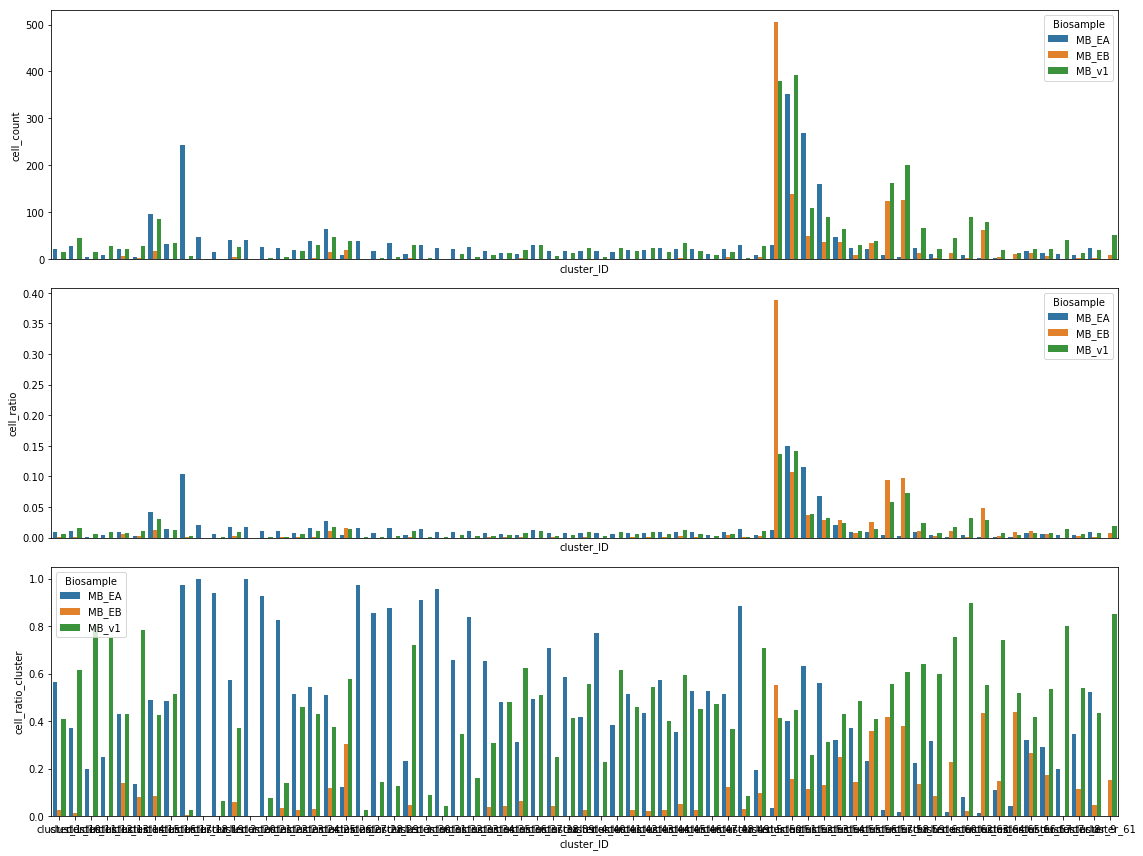

In [26]:
fig, axs = plt.subplots(3, 1, figsize=(16, 12))
ax = axs[0]
sns.barplot(x="cluster_ID", y="cell_count", hue="Biosample", data=df_counts_new, ax=ax)
ax.set_xticks([])
ax = axs[1]
sns.barplot(x="cluster_ID", y="cell_ratio", hue="Biosample", data=df_counts_new, ax=ax)
ax.set_xticks([])
ax = axs[2]
sns.barplot(x="cluster_ID", y="cell_ratio_cluster", hue="Biosample", data=df_counts_new, ax=ax)
# ax.set_xticks([])
fig.tight_layout()
plt.show()

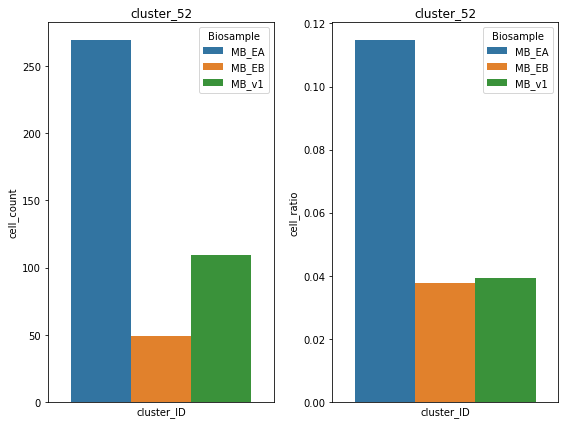

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(8, 6))
ax = axs[0]
sns.barplot(x="cluster_ID", y="cell_count", hue="Biosample", data=df_counts_new[df_counts_new.cluster_ID=='cluster_52'], ax=ax)
ax.set_xticks([])
ax.set_title('cluster_52')
ax = axs[1]
sns.barplot(x="cluster_ID", y="cell_ratio", hue="Biosample", data=df_counts_new[df_counts_new.cluster_ID=='cluster_52'], ax=ax)
ax.set_xticks([])
ax.set_title('cluster_52')
fig.tight_layout()
plt.show()

In [18]:
df_counts_2 = df_info.groupby(['cluster_annotation', 'Biosample']).count()['mCH/CH'].to_frame()
df_counts_2.reset_index(level=['cluster_annotation', 'Biosample'], inplace=True)
df_counts_2.columns = ['cluster_annotation', 'Biosample', 'cell_count']
df_counts_2.head()

df_sample_counts = df_info.groupby('Biosample').count()['mCH/CH'].to_frame()
df_sample_counts.columns = ['tc_biosample']
df_counts_new_2 = pd.merge(df_counts_2, df_sample_counts, left_on='Biosample', right_index=True)
df_counts_new_2['cell_ratio'] = df_counts_new_2.cell_count/df_counts_new_2.tc_biosample

df_cluster_counts = df_info.groupby('cluster_annotation').count()['mCH/CH'].to_frame()
df_cluster_counts.columns = ['tc_cluster']
df_counts_new_2 = pd.merge(df_counts_new_2, df_cluster_counts, left_on='cluster_annotation', right_index=True)
df_counts_new_2['cell_ratio_cluster'] = df_counts_new_2.cell_count/df_counts_new_2.tc_cluster

df_counts_new_2.head()

,cluster_annotation,Biosample,cell_count,tc_biosample,cell_ratio,tc_cluster,cell_ratio_cluster
0,hDL-1,MB_EA,6,2347,0.002556,393,0.015267
1,hDL-1,MB_EB,140,1304,0.107362,393,0.356234
2,hDL-1,MB_v1,247,2784,0.088721,393,0.628499
5,hL2/3,MB_EA,382,2347,0.162761,1800,0.212222
6,hL2/3,MB_EB,645,1304,0.494632,1800,0.358333


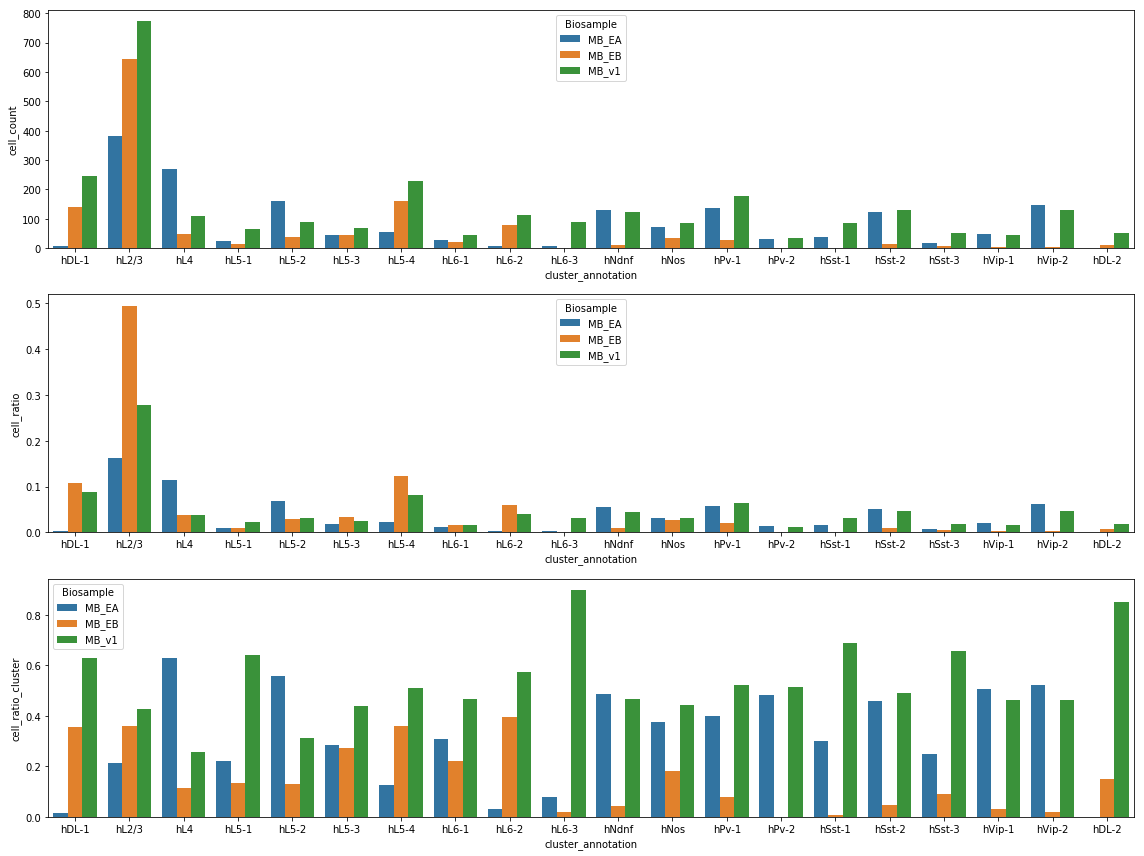

In [27]:
fig, axs = plt.subplots(3, 1, figsize=(16, 12))
ax = axs[0]
sns.barplot(x="cluster_annotation", y="cell_count", hue="Biosample", data=df_counts_new_2, ax=ax)
# ax.set_xticks([])
ax = axs[1]
sns.barplot(x="cluster_annotation", y="cell_ratio", hue="Biosample", data=df_counts_new_2, ax=ax)
# ax.set_xticks([])
ax = axs[2]
sns.barplot(x="cluster_annotation", y="cell_ratio_cluster", hue="Biosample", data=df_counts_new_2, ax=ax)
fig.tight_layout()
plt.show()

In [12]:
# "Among biosample variance"

def sum_of_square(array):
    dev = array - np.mean(array)
    return np.dot(dev, dev)

df_res = pd.DataFrame()
for idx, df_sub in df_info.groupby('cluster_annotation'):
    cells = df_sub.index.values
    variances = df_mcc[cells+'_mcc'].apply(sum_of_square, axis=1)
    for idx2, df_sub2 in df_sub.groupby('Biosample'):
        cells_bio = df_sub2.index.values
        variances -= df_mcc[cells_bio+'_mcc'].apply(sum_of_square, axis=1)
    df_res[idx] = variances/cells.shape[0]
    
df_res.head()


,hDL-1,hDL-2,hL2/3,hL4,hL5-1,hL5-2,hL5-3,hL5-4,hL6-1,hL6-2,hL6-3,hNdnf,hNos,hPv-1,hPv-2,hSst-1,hSst-2,hSst-3,hVip-1,hVip-2
id,,,,,,,,,,,,,,,,,,,,
ENSG00000000457.9,0.000007,2.617120e-06,0.000003,9.369687e-08,2.997738e-07,6.284281e-06,0.000004,0.000002,0.000002,8.066722e-07,0.000003,0.000013,9.318130e-07,0.000007,3.928923e-08,5.316759e-06,0.000004,0.000036,2.195314e-07,3.423277e-07
ENSG00000000460.12,0.000093,1.629989e-06,0.000109,8.934592e-07,3.164436e-05,8.939722e-06,0.000095,0.000055,0.000099,1.158808e-05,0.000029,0.000022,6.173921e-06,0.000030,3.629339e-06,7.277515e-06,0.000007,0.000013,1.191730e-07,3.747798e-06
ENSG00000000971.11,0.000062,7.884891e-07,0.000045,4.016489e-06,9.480584e-06,5.681488e-06,0.000067,0.000028,0.000060,1.185354e-05,0.000015,0.000014,1.222075e-06,0.000042,2.591233e-06,5.523597e-07,0.000015,0.000034,4.766552e-07,1.190588e-06
ENSG00000001084.6,0.000059,1.394214e-07,0.000043,2.693219e-06,2.055926e-05,7.691091e-06,0.000045,0.000049,0.000084,1.602238e-05,0.000034,0.000041,1.680300e-05,0.000023,2.112334e-07,1.791928e-06,0.000008,0.000015,2.397541e-06,2.274661e-06
ENSG00000001460.13,0.000046,4.272873e-07,0.000065,2.732445e-07,2.182005e-05,5.814304e-07,0.000054,0.000081,0.000097,5.730132e-06,0.000004,0.000047,1.130545e-05,0.000055,9.455844e-06,2.103957e-05,0.000021,0.000009,3.942726e-06,1.695198e-06


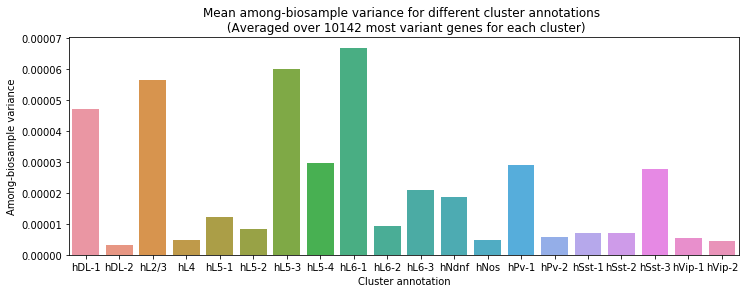

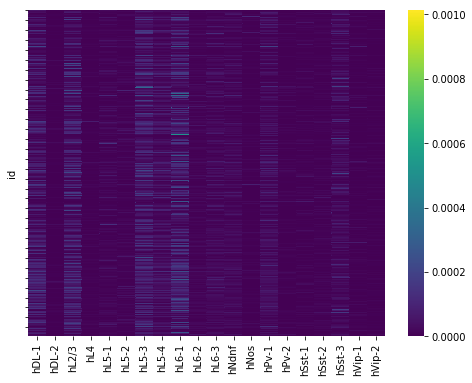

In [35]:
# top few variant gene for each cluster

df_res_top = df_res.mean(axis=0).to_frame()
df_res_top.reset_index(level=0, inplace=True)
df_res_top.columns = ['Cluster annotation', 'Among-biosample variance']

fig, ax = plt.subplots(figsize=(12, 4))
sns.barplot(x='Cluster annotation', y='Among-biosample variance', data=df_res_top, ax=ax)
ax.set_title('Mean among-biosample variance for different cluster annotations \n (Averaged over 10142 most variant genes for each cluster)')
plt.show()

fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(df_res, cmap='viridis', ax=ax)
ax.set_yticklabels([])
plt.show()

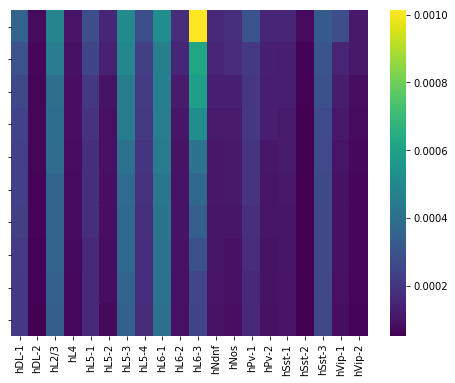

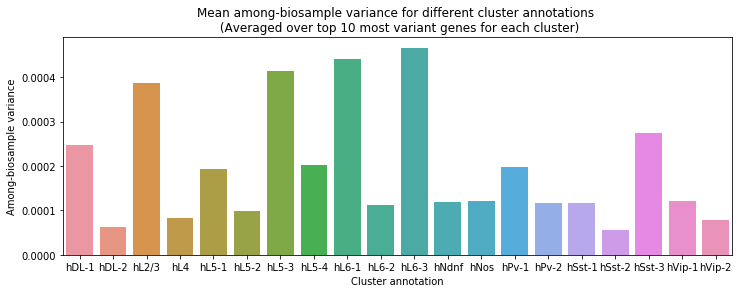

In [36]:
# top few variant genes for each cluster
n_top = 10 

df_res_ntop = pd.DataFrame()
for col in df_res.columns:
    df_res_ntop[col] = df_res[col].sort_values(ascending=False)[:n_top].values


fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(df_res_ntop, cmap='viridis', ax=ax)
ax.set_yticklabels([])
plt.show()

df_plot = df_res_ntop.mean(axis=0).to_frame()
df_plot.reset_index(level=0, inplace=True)
df_plot.columns = ['Cluster annotation', 'Among-biosample variance']

fig, ax = plt.subplots(figsize=(12, 4))
sns.barplot(x='Cluster annotation', y='Among-biosample variance', data=df_plot, ax=ax)
ax.set_title('Mean among-biosample variance for different cluster annotations \n (Averaged over top 10 most variant genes for each cluster)')
plt.show()